# MixMatch Training for Binary Classification

In [11]:
import torch
import torchinfo
import matplotlib.pyplot as plt
import os

In [12]:
import mixmatch
import data_utils
import data_pl_utils
import viz_utils
import models

In [13]:
import importlib
print(importlib.reload(mixmatch))
print(importlib.reload(data_pl_utils))
print(importlib.reload(data_utils))
print(importlib.reload(viz_utils))
print(importlib.reload(models))

<module 'mixmatch' from 'c:\\Users\\josep\\Code\\School\\L3D\\Project\\PL\\mixmatch.py'>
<module 'data_pl_utils' from 'c:\\Users\\josep\\Code\\School\\L3D\\Project\\PL\\data_pl_utils.py'>
<module 'data_utils' from 'c:\\Users\\josep\\Code\\School\\L3D\\Project\\PL\\data_utils.py'>
<module 'viz_utils' from 'c:\\Users\\josep\\Code\\School\\L3D\\Project\\PL\\viz_utils.py'>
<module 'models' from 'c:\\Users\\josep\\Code\\School\\L3D\\Project\\PL\\models.py'>


# Configuration

In [14]:
device = 'cuda'
# device = 'cpu'

In [15]:
PL_DATA_DIR = os.environ.get('DATA_DIR', os.path.abspath('../l3d_pn_dataset500PL'))

# 1. Setup Model

# Define the model (example using ResNet18)

In [16]:
import torch.nn as nn
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, num_classes):
        super(ResNetFeatureExtractor, self).__init__()
        # Load pre-trained ResNet
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC
        self.fc = nn.Linear(resnet.fc.in_features, num_classes)  # Custom FC layer

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)  # Flatten
        out = self.fc(features)
        return out

In [17]:
model = models.PretrainedResNetForPN(
    src_dataset='ImageNet1k',
    arch='ResNet10',
    model_dir='.',
    n_trainable_layers=3,
    n_target_classes=2,  # Binary classification
    seed=42
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Setup complete. Trainable parameter count=133122 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.


In [18]:
torchinfo.summary(model, (1, 3, 224, 224),
                  row_settings=['var_names'],
                  col_names=["output_size", "num_params"],
                  col_width=18)

Layer (type (var_name))                                 Output Shape       Param #
PretrainedResNetForPN (PretrainedResNetForPN)           [1, 2]             --
├─ResNet (model)                                        [1, 2]             --
│    └─Sequential (features)                            [1, 512, 1, 1]     --
│    │    └─ResInitBlock (init_block)                   [1, 64, 56, 56]    (9,536)
│    │    └─Sequential (stage1)                         [1, 64, 56, 56]    (73,984)
│    │    └─Sequential (stage2)                         [1, 128, 28, 28]   (230,144)
│    │    └─Sequential (stage3)                         [1, 256, 14, 14]   (919,040)
│    │    └─Sequential (stage4)                         [1, 512, 7, 7]     3,673,088
│    │    └─AvgPool2d (final_pool)                      [1, 512, 1, 1]     --
│    └─Linear (output)                                  [1, 2]             1,026
Total params: 4,906,818
Trainable params: 133,122
Non-trainable params: 4,773,696
Total mult-adds (Uni

# 2. Prepare Data

# Create initial data loaders

In [19]:
train_loader, val_loader, test_loader = data_utils.make_data_loaders(
    root=PL_DATA_DIR,
    batch_size=32,
    n_samples_per_class_trainandvalid=125,
    frac_valid=0.2
)


splitname   0   1
 lp_train 100 100
 lp_valid  25  25
  lp_test 125 125


# Create MixMatch specific loaders (labeled and unlabeled splits)

# 3. Initialize MixMatch

In [20]:
mixmatch = mixmatch.MixMatch(
    model=model,
    num_augmentations=3,
    temperature=0.5,
    alpha=0.75,
    lambda_u=50,
    device=device
)

# 4. Train Model

In [21]:
# Define optimizer with only trainable parameters
optimizer = torch.optim.Adam(model.trainable_params.values(), lr=0.0001)

model, history = mixmatch.train(
    tr_loader=train_loader,
    va_loader=val_loader,
    num_epochs=100,
    learning_rate=0.0001,  # This will be used if optimizer is not provide
    optimizer=optimizer  # Pass the custom optimizer
)


  1%|          | 1/101 [00:01<02:01,  1.22s/it, tr_loss=nan, va_loss=0.856, va_acc=48]


TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

# 5. Visualize Results

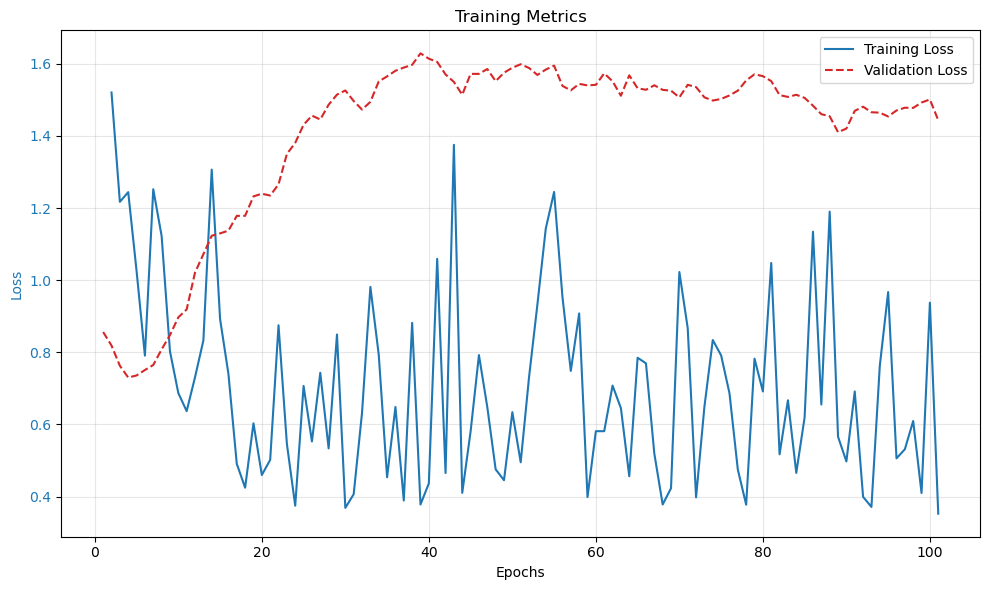

In [ ]:
fig = viz_utils.plot_training_metrics(
    training_history=history,
)
plt.show()

# Train code from YU1ut

In [ ]:
if not os.path.isdir(args.out):
    mkdir_p(args.out)

# Data
print('==> Preparing cifar10')
transform_train = transforms.Compose([
    dataset.RandomPadandCrop(32),
    dataset.RandomFlip(),
    dataset.ToTensor(),
])

transform_val = transforms.Compose([
    dataset.ToTensor(),
])

train_labeled_set, train_unlabeled_set, val_set, test_set = dataset.get_cifar10('./data', args.n_labeled, transform_train=transform_train, transform_val=transform_val)
labeled_trainloader = data.DataLoader(train_labeled_set, batch_size=args.batch_size, shuffle=True, num_workers=0, drop_last=True)
unlabeled_trainloader = data.DataLoader(train_unlabeled_set, batch_size=args.batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=args.batch_size, shuffle=False, num_workers=0)
test_loader = data.DataLoader(test_set, batch_size=args.batch_size, shuffle=False, num_workers=0)

# Model
print("==> creating WRN-28-2")

def create_model(ema=False):
    model = models.WideResNet(num_classes=10)
    model = model.cuda()

    if ema:
        for param in model.parameters():
            param.detach_()

    return model

model = create_model()
ema_model = create_model(ema=True)

cudnn.benchmark = True
print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))

train_criterion = SemiLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

ema_optimizer= WeightEMA(model, ema_model, alpha=args.ema_decay)
start_epoch = 0

# Resume
title = 'noisy-cifar-10'
if args.resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isfile(args.resume), 'Error: no checkpoint directory found!'
    args.out = os.path.dirname(args.resume)
    checkpoint = torch.load(args.resume)
    best_acc = checkpoint['best_acc']
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    ema_model.load_state_dict(checkpoint['ema_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    logger = Logger(os.path.join(args.out, 'log.txt'), title=title, resume=True)
else:
    logger = Logger(os.path.join(args.out, 'log.txt'), title=title)
    logger.set_names(['Train Loss', 'Train Loss X', 'Train Loss U',  'Valid Loss', 'Valid Acc.', 'Test Loss', 'Test Acc.'])

writer = SummaryWriter(args.out)
step = 0
test_accs = []
# Train and val
for epoch in range(start_epoch, args.epochs):

    print('\nEpoch: [%d | %d] LR: %f' % (epoch + 1, args.epochs, state['lr']))

    train_loss, train_loss_x, train_loss_u = train(labeled_trainloader, unlabeled_trainloader, model, optimizer, ema_optimizer, train_criterion, epoch, use_cuda)
    _, train_acc = validate(labeled_trainloader, ema_model, criterion, epoch, use_cuda, mode='Train Stats')
    val_loss, val_acc = validate(val_loader, ema_model, criterion, epoch, use_cuda, mode='Valid Stats')
    test_loss, test_acc = validate(test_loader, ema_model, criterion, epoch, use_cuda, mode='Test Stats ')

    step = args.train_iteration * (epoch + 1)

    writer.add_scalar('losses/train_loss', train_loss, step)
    writer.add_scalar('losses/valid_loss', val_loss, step)
    writer.add_scalar('losses/test_loss', test_loss, step)

    writer.add_scalar('accuracy/train_acc', train_acc, step)
    writer.add_scalar('accuracy/val_acc', val_acc, step)
    writer.add_scalar('accuracy/test_acc', test_acc, step)

    # append logger file
    logger.append([train_loss, train_loss_x, train_loss_u, val_loss, val_acc, test_loss, test_acc])

    # save model
    is_best = val_acc > best_acc
    best_acc = max(val_acc, best_acc)
    save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'ema_state_dict': ema_model.state_dict(),
            'acc': val_acc,
            'best_acc': best_acc,
            'optimizer' : optimizer.state_dict(),
        }, is_best)
    test_accs.append(test_acc)
logger.close()
writer.close()

print('Best acc:')
print(best_acc)

print('Mean acc:')
print(np.mean(test_accs[-20:]))